In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Full data

In [3]:
df = pd.read_json("results/task1/task1_data.json", lines=True)
#replace llama3.2 in the model column with llama3b
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
#replace llama3.2 in the model column with llama3b

#replace llama3.2 in the model column with llama3b
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')

df.drop(columns=['all_fit'], inplace=True)

df.rename(
    columns={
        'c_all_fit_hits': 'correct_match',
        'r_all_fit_hits': 'related_match',
        'r_all_fit_recall': 'related_recall'
    },
    inplace=True
)

code_path = "datasets/occupation.xlsx"
zone_path = "datasets/job_zone.xlsx"
# Read the Excel file
occupation = pd.read_excel(code_path)
occupation.drop(columns=['Description'], inplace=True)
occupation.columns = ['code', 'title']

zone = pd.read_excel(zone_path)
zone = zone[['Title', 'Job Zone']]
zone.columns = ['title', 'zone']

# Merge the occupation data with the main dataframe
df = df.merge(occupation, left_on='title', right_on='title', how='left')
df = df.merge(zone, left_on='title', right_on='title', how='left')
df["industry"] = df["code"].apply(lambda x: x.split("-")[0])
df

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,industry
0,Chief Executives,0,1,1,0.5,deepseek-r1,benchmark,11-1011.00,5,11
1,Chief Sustainability Officers,0,1,1,0.1,deepseek-r1,benchmark,11-1011.03,5,11
2,General and Operations Managers,0,0,0,0.0,deepseek-r1,benchmark,11-1021.00,4,11
3,Legislators,0,0,0,0.0,deepseek-r1,benchmark,11-1031.00,4,11
4,Advertising and Promotions Managers,0,0,1,0.9,deepseek-r1,benchmark,11-2011.00,4,11
...,...,...,...,...,...,...,...,...,...,...
73835,Gas Compressor and Gas Pumping Station Operators,9,0,1,0.2,mistral,persona,53-7071.00,2,53
73836,"Pump Operators, Except Wellhead Pumpers",9,0,0,0.0,mistral,persona,53-7072.00,2,53
73837,Wellhead Pumpers,9,0,0,0.0,mistral,persona,53-7073.00,2,53
73838,Refuse and Recyclable Material Collectors,9,0,0,0.0,mistral,persona,53-7081.00,2,53


Averaged match rate

In [4]:
df_avg = df.groupby(["title", "model", "prompt", "code", "zone", "industry"]).mean().reset_index().drop(columns=["iteration"])
df_avg

,title,model,prompt,code,zone,industry,correct_match,related_match,related_recall
0,Accountants and Auditors,deepseek-r1,benchmark,13-2011.00,4,13,0.0,0.0,0.00
1,Accountants and Auditors,deepseek-r1,persona,13-2011.00,4,13,0.0,1.0,0.59
2,Accountants and Auditors,llama3b,benchmark,13-2011.00,4,13,0.0,1.0,0.56
3,Accountants and Auditors,llama3b,persona,13-2011.00,4,13,0.0,1.0,0.60
4,Accountants and Auditors,llama70b,benchmark,13-2011.00,4,13,0.0,1.0,0.56
...,...,...,...,...,...,...,...,...,...
7379,Zoologists and Wildlife Biologists,llama3b,persona,19-1023.00,4,19,0.0,1.0,0.40
7380,Zoologists and Wildlife Biologists,llama70b,benchmark,19-1023.00,4,19,0.0,1.0,0.33
7381,Zoologists and Wildlife Biologists,llama70b,persona,19-1023.00,4,19,0.0,1.0,0.39
7382,Zoologists and Wildlife Biologists,mistral,benchmark,19-1023.00,4,19,0.0,0.0,0.00


Correct Match Pivot

In [5]:
df_pivot = df.pivot_table(index=["title", "industry", "zone", "model", "iteration"], columns=["prompt"], values="correct_match").reset_index()
df_pivot["difference"] = df_pivot["persona"] - df_pivot["benchmark"]
df_related_hit_pivot = df.pivot_table(index=["title", "industry", "zone", "model", "iteration"], columns=["prompt"], values="related_match").reset_index()
df_related_hit_pivot["difference"] = df_related_hit_pivot["persona"] - df_related_hit_pivot["benchmark"]
df_recall_pivot = df.pivot_table(index=["title", "industry", "zone", "model", "iteration"], columns=["prompt"], values="related_recall").reset_index()
df_recall_pivot["difference"] = df_recall_pivot["persona"] - df_recall_pivot["benchmark"]
df_pivot

prompt,title,industry,zone,model,iteration,benchmark,persona,difference
0,Accountants and Auditors,13,4,deepseek-r1,0,0.0,0.0,0.0
1,Accountants and Auditors,13,4,deepseek-r1,1,0.0,0.0,0.0
2,Accountants and Auditors,13,4,deepseek-r1,2,0.0,0.0,0.0
3,Accountants and Auditors,13,4,deepseek-r1,3,0.0,0.0,0.0
4,Accountants and Auditors,13,4,deepseek-r1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
36915,Zoologists and Wildlife Biologists,19,4,mistral,5,0.0,0.0,0.0
36916,Zoologists and Wildlife Biologists,19,4,mistral,6,0.0,0.0,0.0
36917,Zoologists and Wildlife Biologists,19,4,mistral,7,0.0,0.0,0.0
36918,Zoologists and Wildlife Biologists,19,4,mistral,8,0.0,0.0,0.0


In [6]:
deepseek = df_avg[df_avg["model"] == "deepseek-r1"]
llama3b = df_avg[df_avg["model"] == "llama3b"]
llama70b = df_avg[df_avg["model"] == "llama70b"]
mistral = df_avg[df_avg["model"] == "mistral"]

### Descriptive Stats

### Correct Match

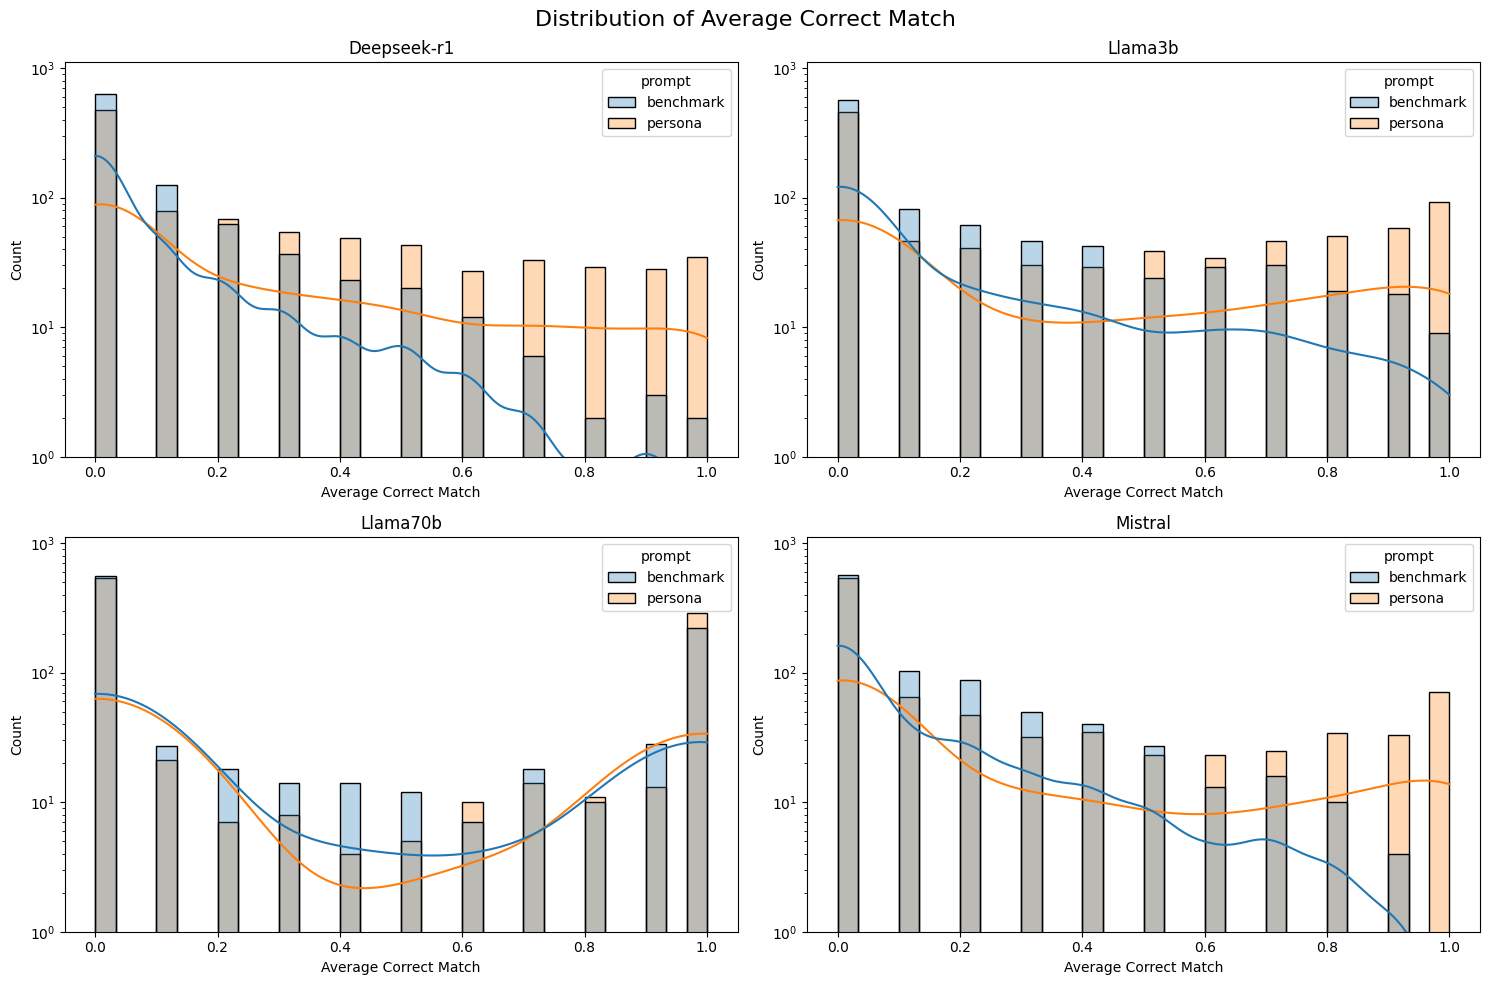

In [7]:
plt.figure(figsize=(15, 10))

# Calculate the maximum y-value across all plots
max_y = max(
    deepseek["correct_match"].value_counts().max(),
    llama3b["correct_match"].value_counts().max(),
    llama70b["correct_match"].value_counts().max(),
    mistral["correct_match"].value_counts().max()
)
#add a title to the plot
plt.suptitle("Distribution of Average Correct Match", fontsize=16)
# Plot the distribution of the data
plt.subplot(2, 2, 1)
sns.histplot(data=deepseek, x="correct_match", hue="prompt", bins=30, kde=True, alpha=0.3)
plt.xlabel("Average Correct Match")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Deepseek-r1")

plt.subplot(2, 2, 2)
sns.histplot(data=llama3b, x="correct_match", hue="prompt", bins=30, kde=True, alpha=0.3)
plt.xlabel("Average Correct Match")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama3b")

plt.subplot(2, 2, 3)
sns.histplot(data=llama70b, x="correct_match", hue="prompt", bins=30, kde=True, alpha=0.3)
plt.xlabel("Average Correct Match")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama70b")

plt.subplot(2, 2, 4)
sns.histplot(data=mistral, x="correct_match", hue="prompt", bins=30, kde=True, alpha=0.3)
plt.xlabel("Average Correct Match")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Mistral")

plt.tight_layout()
plt.show()

more occupations get a higher correct match rate using persona than benchmark. For llama70b, more occupations get a 100% correct match than benchmark.

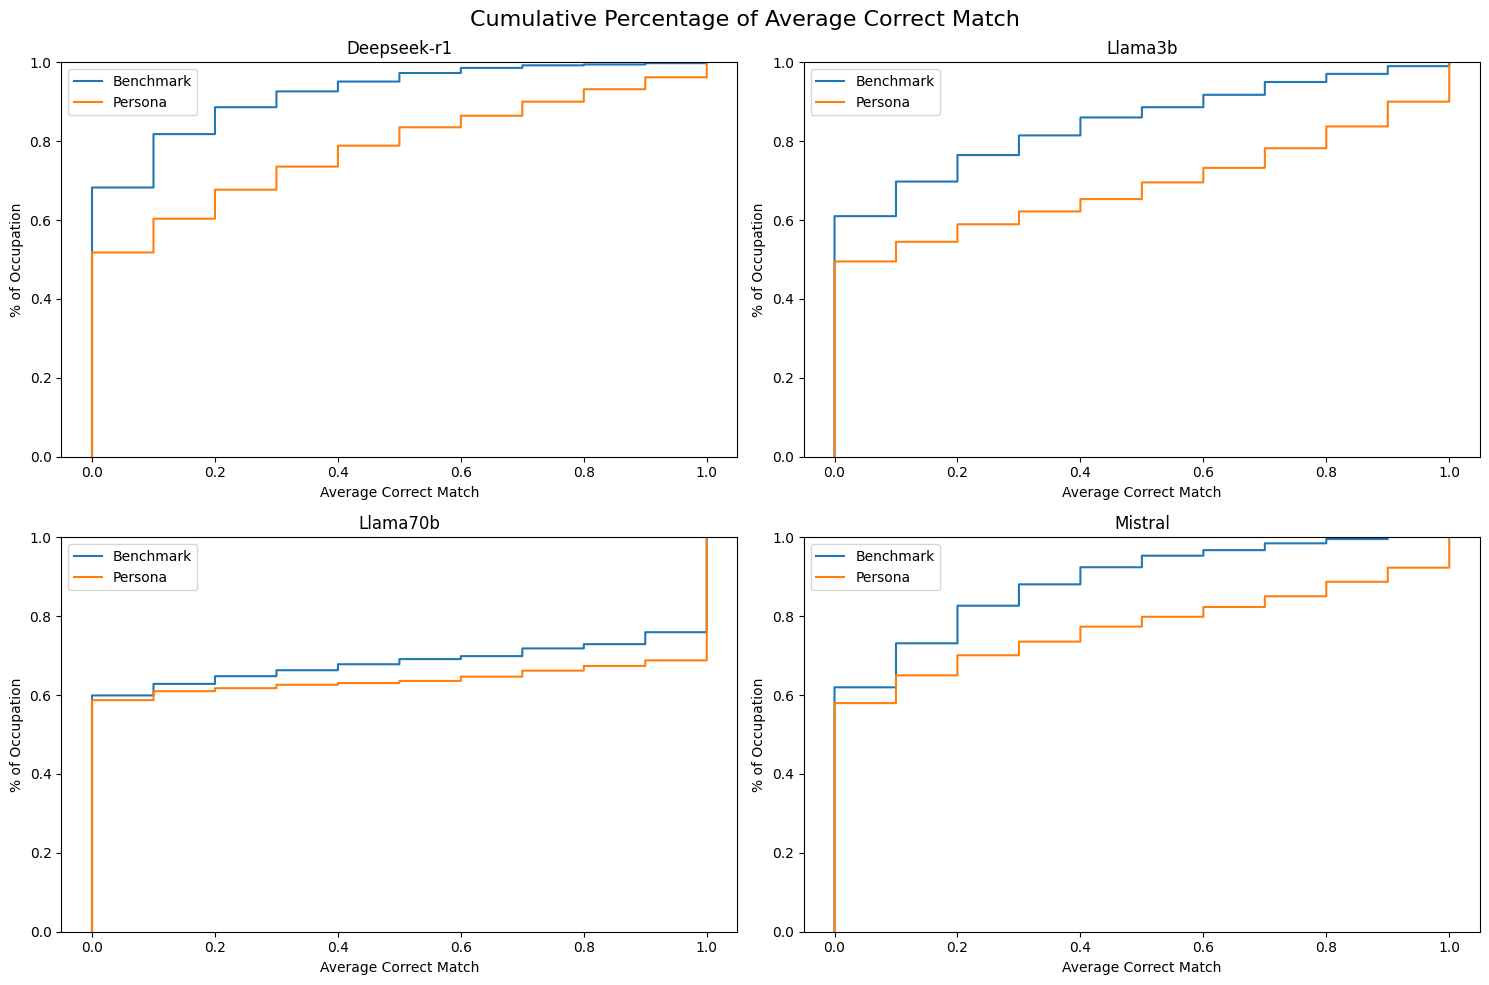

In [8]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]
plt.figure(figsize=(15, 10))
plt.suptitle("Cumulative Percentage of Average Correct Match", fontsize=16)
for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    for prompt in ["benchmark", "persona"]:
        data_subset = df_avg[(df_avg["model"] == model) & (df_avg["prompt"] == prompt)]
        sns.ecdfplot(data=data_subset, x="correct_match", label=prompt.capitalize(), )
    plt.title(f"{model.capitalize()}")
    plt.xlabel("Average Correct Match")
    plt.ylabel("% of Occupation")
    plt.legend()

plt.tight_layout()
plt.show()

looking at Average correct match = 0, at least half of the occupation do not get a match in all 10 rounds. However, persona prompt helped more occupation to get more matches.

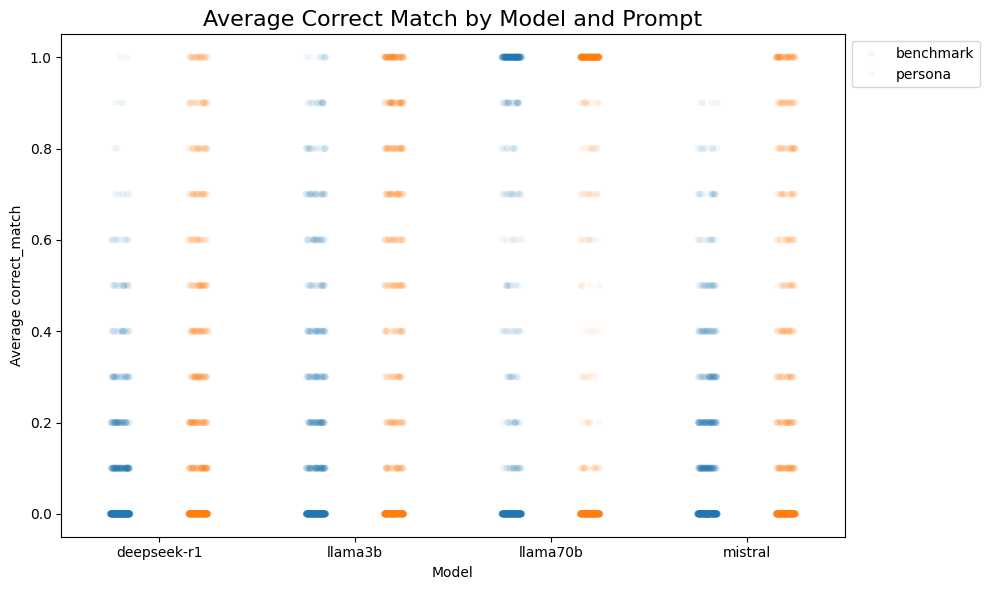

In [9]:
# Calculate the average correct_match for each model and prompt
avg_hits = df_avg.groupby(["model", "prompt"])["correct_match"].mean().reset_index()

# Create a single barplot
plt.figure(figsize=(10, 6))
# sns.violinplot(data=df_avg, x="model", y="correct_match", hue="prompt", bw_adjust=3)
sns.stripplot(data=df_avg, x="model", y="correct_match", hue="prompt", dodge=True, 
              size=5, alpha=0.05, jitter=True)

# Add labels and title
plt.title("Average Correct Match by Model and Prompt", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average correct_match")
 # Ensure some padding on the y-axis, no box around the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

for model in models:
    # Filter the dataframe for the current model
    model_data = df_pivot[df_pivot['model'] == model].copy()
    model_data = model_data.groupby(["title", "model", "industry", "zone"]).mean().reset_index().drop(columns=["iteration"])
    model_data['difference'] = model_data['persona'] - model_data['benchmark']

    # Perform the Wilcoxon signed-rank test on the differences
    statistic, p_value = stats.wilcoxon(model_data['persona'], model_data["benchmark"], alternative='greater')
    # Print the results

    print(f"Model: {model}")
    print("Wilcoxon Signed-Rank Test Results:")
    print(f"  W-statistic: {statistic:.4f}")
    print(f"  p-value: {p_value:.4f}")

    # Interpretation of the p-value
    alpha = 0.01  # significance level
    if p_value < alpha:
        print(f"\nThe p-value ({p_value:.4f}) is less than the significance level ({alpha}).")
        print("This suggests that there is a statistically significant difference in the similarity scores")
        print("between the benchmark and persona conditions across all occupations and iterations.")
        print("We reject the null hypothesis that there is no difference.")
    else:
        print(f"\nThe p-value ({p_value:.4f}) is greater than or equal to the significance level ({alpha}).")
        print("This suggests that there is no statistically significant difference in the similarity scores")
        print("between the benchmark and persona conditions across all occupations and iterations.")
        print("We fail to reject the null hypothesis.")
    print("\n" + "-" * 50 + "\n")


Model: deepseek-r1
Wilcoxon Signed-Rank Test Results:
  W-statistic: 80041.5000
  p-value: 0.0000

The p-value (0.0000) is less than the significance level (0.01).
This suggests that there is a statistically significant difference in the similarity scores
between the benchmark and persona conditions across all occupations and iterations.
We reject the null hypothesis that there is no difference.

--------------------------------------------------

Model: llama3b
Wilcoxon Signed-Rank Test Results:
  W-statistic: 90229.0000
  p-value: 0.0000

The p-value (0.0000) is less than the significance level (0.01).
This suggests that there is a statistically significant difference in the similarity scores
between the benchmark and persona conditions across all occupations and iterations.
We reject the null hypothesis that there is no difference.

--------------------------------------------------

Model: llama70b
Wilcoxon Signed-Rank Test Results:
  W-statistic: 13991.0000
  p-value: 0.0000

The 

Simple non parametric t-test (wilcoxon test) shows the average match rate of persona prompt differs from the benchmark and is statistically significant.

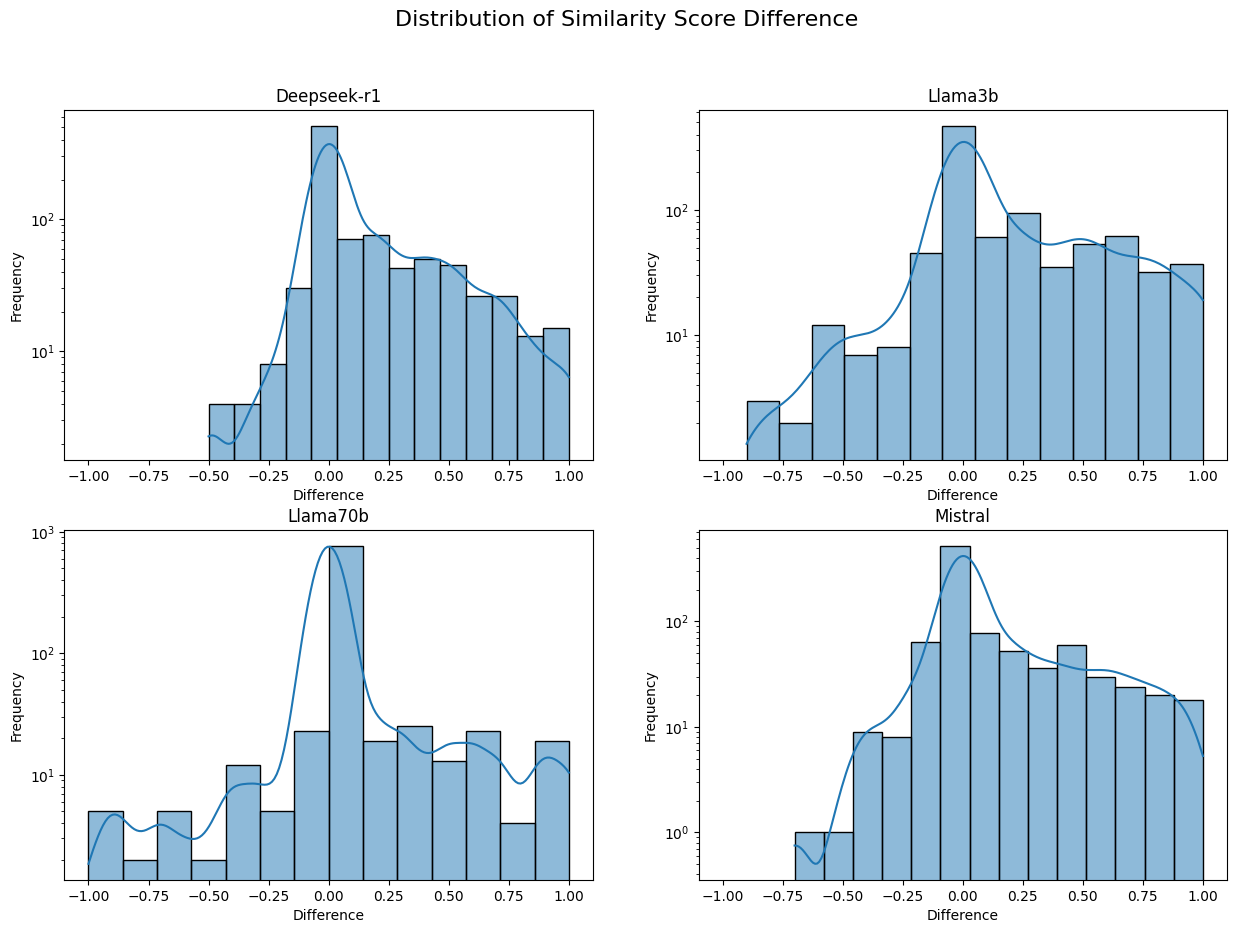

In [11]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(15, 10))
plt.suptitle("Distribution of Similarity Score Difference", fontsize=16)
for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    data_subset = df_pivot[(df_pivot["model"] == model)]
    data_subset = data_subset.groupby('title')['difference'].mean().reset_index()
    sns.histplot(data=data_subset, x="difference", bins=14, kde=True)
    plt.title(f"{model.capitalize()}")
    # plt.ylim(1, max_y)  # Set the same y-axis limit
    plt.xlim(-1.1, 1.1)  # Set the same x-axis limit
    plt.xlabel("Difference")
    plt.yscale('log')
    plt.ylabel("Frequency")

looking at the change in matching rate for eaach jobs, most jobs didnt get a boost (0 match rate). more jobs gets a boost of matching rate, although some jobs perform poorer using persona than benchmark.

In [12]:
#get a df to show the average correct match rate by model and prompt
avg_hits = df_avg.groupby(["model", "prompt"])["correct_match"].mean().reset_index()
avg_hits = avg_hits.pivot(index="model", columns="prompt", values="correct_match").reset_index()
avg_hits.columns.name = None  # Remove the name of the columns
avg_hits = avg_hits.rename(columns={"benchmark": "average_benchmark", "persona": "average_persona"})
avg_hits["difference"] = avg_hits["average_persona"] - avg_hits["average_benchmark"]
avg_hits["percentage_difference"] = (avg_hits["difference"] / avg_hits["average_benchmark"]) * 100
avg_hits = avg_hits.sort_values(by="percentage_difference", ascending=False)
avg_hits

,model,average_benchmark,average_persona,difference,percentage_difference
0,deepseek-r1,0.079198,0.218310,0.139112,175.649795
1,llama3b,0.153738,0.314735,0.160997,104.721635
3,mistral,0.111593,0.227736,0.116143,104.077670
2,llama70b,0.318635,0.362189,0.043554,13.668820


deepseek receives the largest boost. notably after the use of persona, llama 3b perform comparably to 70b model.

## correct match by industry and zone

In [13]:
df_industry = df_pivot[["model", "iteration", "industry", "persona", "benchmark"]]
df_industry = df_industry.groupby(["model", "iteration", "industry"]).mean().reset_index()
df_industry

prompt,model,iteration,industry,persona,benchmark
0,deepseek-r1,0,11,0.392857,0.285714
1,deepseek-r1,0,13,0.354167,0.062500
2,deepseek-r1,0,15,0.361111,0.166667
3,deepseek-r1,0,17,0.142857,0.000000
4,deepseek-r1,0,19,0.216667,0.050000
...,...,...,...,...,...
875,mistral,9,45,0.166667,0.250000
876,mistral,9,47,0.114754,0.098361
877,mistral,9,49,0.140000,0.060000
878,mistral,9,51,0.056075,0.009346


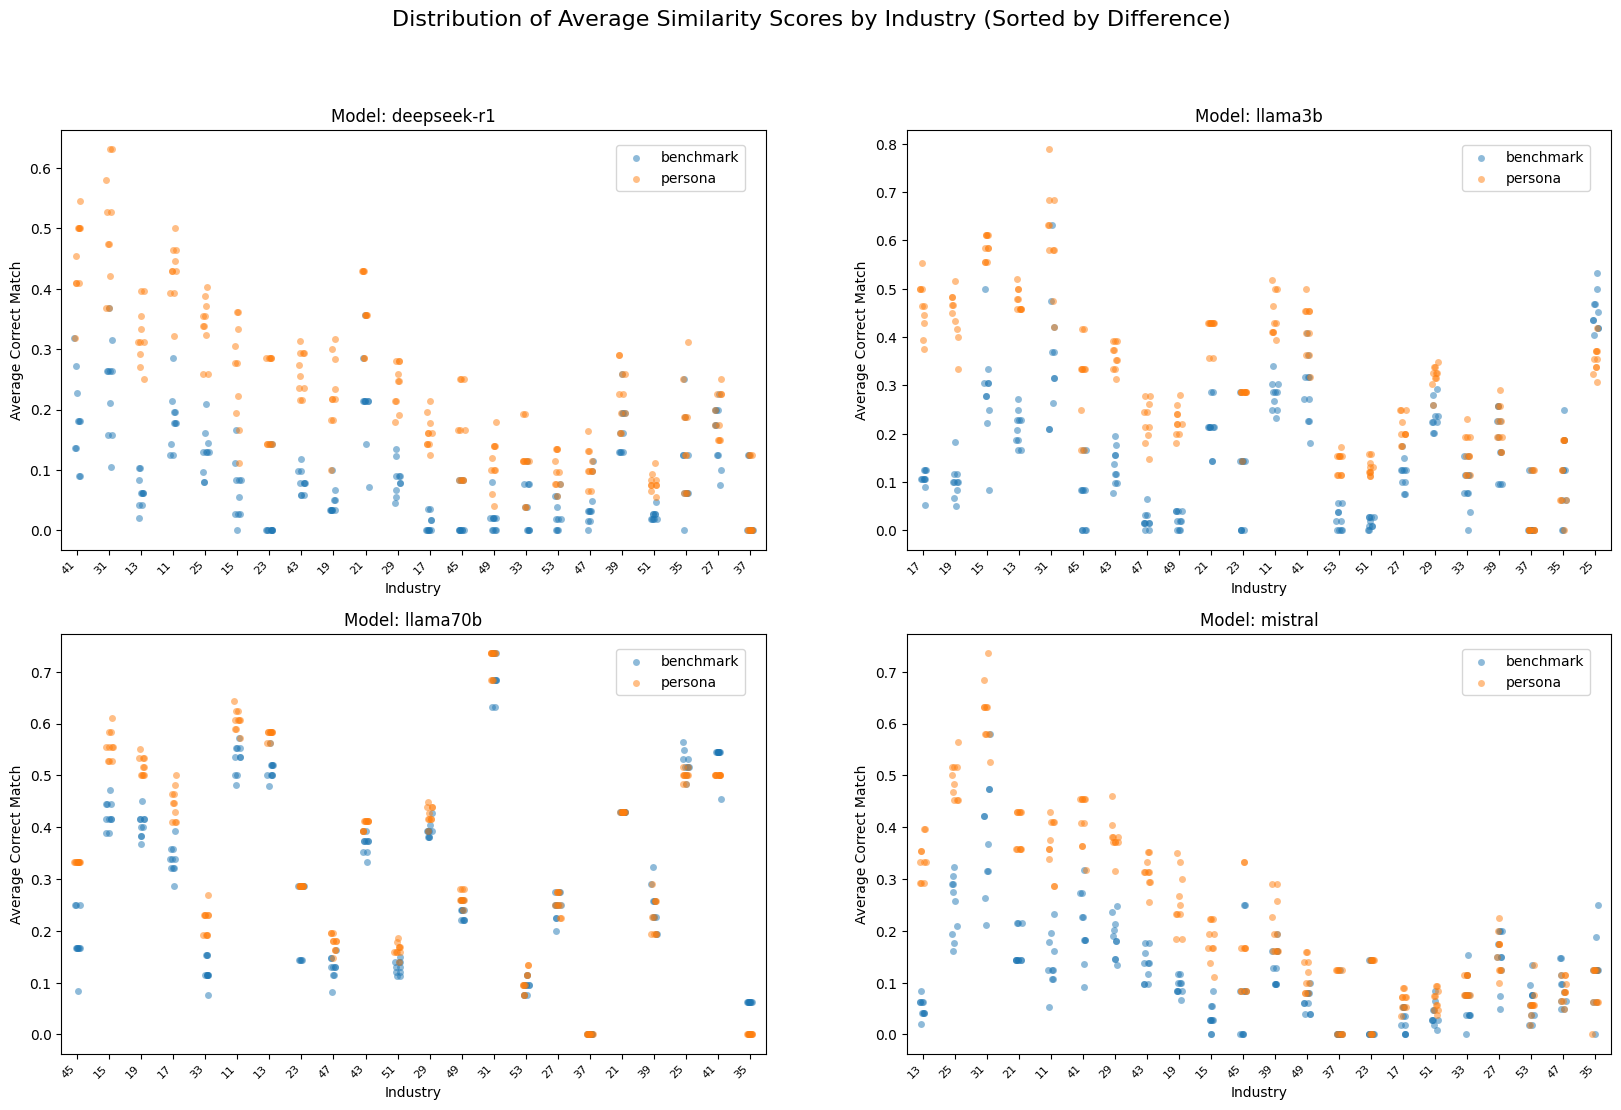

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 12))
plt.suptitle("Distribution of Average Similarity Scores by Industry (Sorted by Difference)", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_industry[df_industry['model'] == model].copy()

    # Calculate the difference for sorting industries
    df_diff = df_model.groupby('industry')[['benchmark', 'persona']].mean()
    df_diff['difference'] = df_diff['persona'] - df_diff['benchmark']
    df_diff_sorted = df_diff.sort_values(by='difference', ascending=False).index

    # Use the sorted order for the stripplot
    sns.stripplot(x='industry', y='benchmark', label='benchmark', data=df_model, dodge=False, alpha=0.5, order=df_diff_sorted)
    sns.stripplot(x='industry', y='persona', label='persona', data=df_model, dodge=False, alpha=0.5, order=df_diff_sorted)
    

    plt.title(f'Model: {model}')
    plt.xlabel('Industry')
    plt.ylabel('Average Correct Match')
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[21:23], labels[21:23], loc='upper right', bbox_to_anchor=(0.98, 0.98))


plt.show()

boost of persona shown in industry. on the right side, it shows that for some industries, persona prompt effect is not obvious, or even detrimental. 

In [15]:
import statsmodels.formula.api as smf
df_regression = df_pivot.groupby(["model", "title", "industry"]).mean().reset_index().drop(columns=["iteration"])
df_regression['industry'] = pd.Categorical(df_regression['industry'])
df_regression['zone'] = pd.Categorical(df_regression['zone'])
df_regression = df_regression.melt(id_vars=['model', 'title', 'industry', 'zone'],
                             value_vars=['benchmark', 'persona'],
                             var_name='prompt',
                             value_name='average_similarity_score')
df_regression = df_regression[df_regression['model'] == "mistral"].copy()
# Model the similarity score ('all_fit') as a function of prompt, industry, job_zone, and their interactions
formula_with_prompt = 'average_similarity_score ~ C(prompt)'# * C(industry)'
model_with_prompt = smf.ols(formula_with_prompt, data=df_regression)
results_with_prompt = model_with_prompt.fit()

print(results_with_prompt.summary())

                               OLS Regression Results                               
Dep. Variable:     average_similarity_score   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     80.97
Date:                      Mon, 19 May 2025   Prob (F-statistic):           5.56e-19
Time:                              00:07:10   Log-Likelihood:                -250.45
No. Observations:                      1846   AIC:                             504.9
Df Residuals:                          1844   BIC:                             516.0
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

above shows prompt has strong effect in increasing matching rate.

In [16]:
model = ["deepseek-r1"]
df_ind = df_avg[df_avg["model"] == model[0]].copy()
df_ind = df_ind.pivot_table(index=["industry"], columns=["prompt"], values="correct_match").mul(100).reset_index()
df_ind["difference"] = df_ind["persona"] - df_ind["benchmark"]
df_ind = df_ind.sort_values(by="difference", ascending=False)
# find out average matching rate for each column
df_ind["benchmark"] = df_ind["benchmark"].apply(lambda x: "{:.2f}%".format(x))
df_ind["persona"] = df_ind["persona"].apply(lambda x: "{:.2f}%".format(x))
df_ind["difference"] = df_ind["difference"].apply(lambda x: "{:.2f}%".format(x))
df_ind

prompt,industry,benchmark,persona,difference
15,41,18.18%,45.45%,27.27%
10,31,23.68%,50.00%,26.32%
1,13,6.46%,32.29%,25.83%
0,11,18.21%,42.68%,24.46%
7,25,12.90%,33.87%,20.97%
2,15,6.67%,26.11%,19.44%
6,23,2.86%,21.43%,18.57%
16,43,8.04%,26.27%,18.24%
4,19,4.67%,22.50%,17.83%
5,21,21.43%,37.14%,15.71%


In [17]:
df_mistral = df[df["model"] == "mistral"].copy()
df_mistral_reg = df_mistral[["title", "industry", "prompt", "related_recall", "zone"]]
df_mistral_reg

,title,industry,prompt,related_recall,zone
55380,Chief Executives,11,benchmark,0.4,5
55381,Chief Sustainability Officers,11,benchmark,0.0,5
55382,General and Operations Managers,11,benchmark,0.5,4
55383,Legislators,11,benchmark,0.0,4
55384,Advertising and Promotions Managers,11,benchmark,0.8,4
...,...,...,...,...,...
73835,Gas Compressor and Gas Pumping Station Operators,53,persona,0.2,2
73836,"Pump Operators, Except Wellhead Pumpers",53,persona,0.0,2
73837,Wellhead Pumpers,53,persona,0.0,2
73838,Refuse and Recyclable Material Collectors,53,persona,0.0,2


In [18]:
zone_industry_counts = pd.crosstab(df_mistral['industry'], df_mistral['zone']).div(10)
zone_industry_counts = zone_industry_counts.astype(int)
zone_industry_counts["sum"] = zone_industry_counts.sum(axis=1)
zone_industry_counts = zone_industry_counts.sort_values(by="sum", ascending=False)
zone_industry_counts

zone,1,2,3,4,5,sum
industry,,,,,,
51,14,162,38,0,0,214
29,0,0,56,18,104,178
25,0,0,14,26,84,124
47,16,84,22,0,0,122
19,0,0,22,40,58,120
11,0,6,14,78,14,112
17,0,2,28,74,8,112
53,2,78,20,4,0,104
43,0,72,26,4,0,102


not a signle industry contains jobs from all 5 zones. so some industry effect might be misinterpreted. thats why 2 regressions will be run, one with prompt x industry, andother is prompt x zone

for prompt x industry, 47 will be used a baseline because benchmark and persona difference is small, closer to average benchmark matching rate, and more frequent in the dataset.

C(prompt)[T.persona]                      -0.0605      0.201     -0.301      0.763      -0.454       0.333 \
persona effect in 47 is small and insignificant, which is expected.

In [19]:
model = ["deepseek-r1"]
df_zone = df_avg[df_avg["model"] == model[0]].copy()
df_zone = df_zone.pivot_table(index=["zone"], columns=["prompt"], values="correct_match").mul(100).reset_index()
df_zone["difference"] = df_zone["persona"] - df_zone["benchmark"]
df_zone = df_zone.sort_values(by="difference", ascending=False)
# find out average matching rate for each column
df_zone["benchmark"] = df_zone["benchmark"].apply(lambda x: "{:.2f}%".format(x))
df_zone["persona"] = df_zone["persona"].apply(lambda x: "{:.2f}%".format(x))
df_zone["difference"] = df_zone["difference"].apply(lambda x: "{:.2f}%".format(x))
df_zone

prompt,zone,benchmark,persona,difference
3,4,8.53%,28.93%,20.40%
4,5,8.38%,27.40%,19.03%
2,3,7.99%,19.41%,11.42%
1,2,7.05%,16.34%,9.29%
0,1,9.03%,12.26%,3.23%


In [20]:
#find out the count of each zone
zone_counts = df_mistral["zone"].value_counts().div(20)
zone_counts = zone_counts.astype(int).reset_index()
zone_counts

,zone,count
0,2,295
1,4,224
2,3,219
3,5,154
4,1,31


C(prompt)[T.persona] shows with persona, it helps increase the log odds by 0.5453 and its significant. \
\
except zone 5, all other zone perform similarly without benchmark. log odds is small and insignificant. \
\
but after persona, zone 4 C(prompt)[T.persona]:C(zone)[T.4] and zone 5 benefit a lot from persona since log odds are high and significant.

The 'persona' prompt has a statistically significant positive effect on the likelihood of a correct match in the reference zone ('2').\
\
The 'persona' prompt also has a significantly more positive effect in Zone '4' and Zone '5' compared to the reference zone. This suggests that the 'persona' prompt is particularly beneficial in these zones.\
\
The effect of the 'persona' prompt in Zone '1' and Zone '3' is not significantly different from its effect in the reference zone.\
\
The baseline matching rates (with the 'benchmark' prompt) differ across zones, with Zone '5' having a significantly higher rate than the reference zone.\
\
more complex job is benefited by persona prompt more.

### Recall

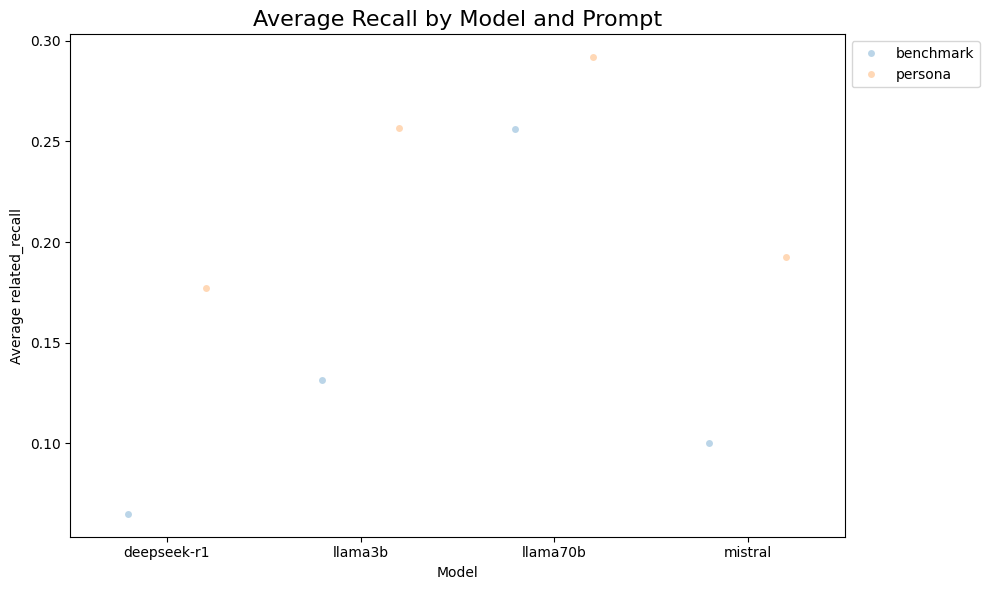

In [21]:
# Calculate the average related_recall for each model and prompt
avg_hits = df.groupby(["model", "prompt"])["related_recall"].mean().reset_index()

# Create a single barplot
plt.figure(figsize=(10, 6))
# sns.violinplot(data=df_avg, x="model", y="related_recall", hue="prompt", bw_adjust=3)
sns.stripplot(data=avg_hits, x="model", y="related_recall", hue="prompt", dodge=True, 
              size=5, alpha=0.3, jitter=True)

# Add labels and title
plt.title("Average Recall by Model and Prompt", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average related_recall")
 # Ensure some padding on the y-axis, no box around the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [22]:

# 2. Melt the DataFrame to long format for correct_match and related_match
df_both = df.drop(columns=['related_recall'])
df_both = df_both.melt(
    id_vars=[col for col in df_both.columns if col not in ['correct_match', 'related_match']],
    value_vars=['correct_match', 'related_match'],
    var_name='task',
    value_name='match'
).reset_index(drop=True)

df_both

,title,iteration,model,prompt,code,zone,industry,task,match
0,Chief Executives,0,deepseek-r1,benchmark,11-1011.00,5,11,correct_match,1
1,Chief Sustainability Officers,0,deepseek-r1,benchmark,11-1011.03,5,11,correct_match,1
2,General and Operations Managers,0,deepseek-r1,benchmark,11-1021.00,4,11,correct_match,0
3,Legislators,0,deepseek-r1,benchmark,11-1031.00,4,11,correct_match,0
4,Advertising and Promotions Managers,0,deepseek-r1,benchmark,11-2011.00,4,11,correct_match,0
...,...,...,...,...,...,...,...,...,...
147675,Gas Compressor and Gas Pumping Station Operators,9,mistral,persona,53-7071.00,2,53,related_match,1
147676,"Pump Operators, Except Wellhead Pumpers",9,mistral,persona,53-7072.00,2,53,related_match,0
147677,Wellhead Pumpers,9,mistral,persona,53-7073.00,2,53,related_match,0
147678,Refuse and Recyclable Material Collectors,9,mistral,persona,53-7081.00,2,53,related_match,0


In [23]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.othermod.betareg as sm_betareg
import statsmodels.genmod.families.links as links
import numpy as np


df_beta = df.copy()
df_beta = df_beta[df_beta["model"] == "deepseek-r1"].copy()

# # Suppose you want 'persona' as the reference for 'prompt'
# df_beta['prompt'] = pd.Categorical(df_beta['prompt'])
# df_beta['prompt'] = df_beta['prompt'].cat.reorder_categories(['persona', 'benchmark'], ordered=False)

# Suppose you want '47' as the reference for 'industry'
industry_categories = ['15'] + [cat for cat in df_beta['industry'].unique() if cat != '15']
df_beta['industry'] = pd.Categorical(df_beta['industry'])
df_beta['industry'] = df_beta['industry'].cat.reorder_categories(industry_categories, ordered=False)
# --- Beta Regression ---
# Beta regression requires the dependent variable to be strictly between 0 and 1.
# If your data contains 0 or 1 values, you need to transform it.
# A common transformation is (y * (n-1) + 0.5) / n, where y is the original value
# and n is the number of observations.

n_obs = len(df_beta)
df_beta['related_recall_transformed'] = (df_beta['related_recall'] * (n_obs - 1) + 0.5) / n_obs

# Define the model formula
# 'related_recall_transformed' is the dependent variable
# 'prompt' and 'industry' are the independent variables
# C(prompt) tells statsmodels to treat 'prompt' as a categorical variable
formula = 'related_recall_transformed ~ C(prompt) * industry'

# Fit the Beta Regression model
# The link='logit' is a common choice for the mean function
# The link_precision='log' is a common choice for the precision function
beta_model = sm_betareg.BetaModel.from_formula(formula, data=df_beta, link=links.logit(), link_precision=links.log())
beta_results = beta_model.fit()

#save the results to a csv file
beta_results_summary = beta_results.summary()
beta_results_summary_df = pd.DataFrame(beta_results_summary.tables[1].data[:], columns=beta_results_summary.tables[1].data[0])
beta_results_summary_df.columns = beta_results_summary_df.iloc[0]
beta_results_summary_df = beta_results_summary_df[1:]
beta_results_summary_df.to_csv("results/task1/beta_regression_industry_results.csv", index=False)
# Print the model summary
beta_results_summary_df



c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


,,coef,std err,z,P>|z|,[0.025,0.975]
1,Intercept,-2.4487,0.057,-42.600,0.000,-2.561,-2.336
2,C(prompt)[T.persona],0.4851,0.081,6.025,0.000,0.327,0.643
3,industry[T.11],0.3600,0.073,4.960,0.000,0.218,0.502
4,industry[T.13],0.0352,0.074,0.473,0.636,-0.111,0.181
5,industry[T.17],-0.1869,0.072,-2.601,0.009,-0.328,-0.046
6,industry[T.19],-0.0113,0.071,-0.159,0.874,-0.151,0.128
7,industry[T.21],0.6603,0.109,6.059,0.000,0.447,0.874
8,industry[T.23],-0.0399,0.139,-0.287,0.774,-0.313,0.233
9,industry[T.25],0.2647,0.071,3.726,0.000,0.125,0.404
10,industry[T.27],0.4005,0.078,5.118,0.000,0.247,0.554


In [24]:
# Suppose you want '47' as the reference for 'zone'
zone_categories = [2] + [cat for cat in df_beta['zone'].unique() if cat != 2]
df_beta['zone'] = pd.Categorical(df_beta['zone'])
df_beta['zone'] = df_beta['zone'].cat.reorder_categories(zone_categories, ordered=False)
# --- Beta Regression ---
# Beta regression requires the dependent variable to be strictly between 0 and 1.
# If your data contains 0 or 1 values, you need to transform it.
# A common transformation is (y * (n-1) + 0.5) / n, where y is the original value
# and n is the number of observations.

n_obs = len(df_beta)
df_beta['related_recall_transformed'] = (df_beta['related_recall'] * (n_obs - 1) + 0.5) / n_obs

# Define the model formula
# 'related_recall_transformed' is the dependent variable
# 'prompt' and 'zone' are the independent variables
# C(prompt) tells statsmodels to treat 'prompt' as a categorical variable
formula = 'related_recall_transformed ~ C(prompt) * zone'

# Fit the Beta Regression model
# The link='logit' is a common choice for the mean function
# The link_precision='log' is a common choice for the precision function
beta_model = sm_betareg.BetaModel.from_formula(formula, data=df_beta, link=links.logit(), link_precision=links.log())
beta_results = beta_model.fit()

#save the results to a csv file
beta_results_summary = beta_results.summary()
beta_results_summary_df = pd.DataFrame(beta_results_summary.tables[1].data[:], columns=beta_results_summary.tables[1].data[0])
beta_results_summary_df.columns = beta_results_summary_df.iloc[0]
beta_results_summary_df = beta_results_summary_df[1:]
# beta_results_summary_df.to_csv("results/task1/beta_regression_zone_results.csv", index=False)
# Print the model summary
beta_results_summary_df

c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


,,coef,std err,z,P>|z|,[0.025,0.975]
1,Intercept,-2.3845,0.023,-103.042,0.000,-2.430,-2.339
2,C(prompt)[T.persona],0.2771,0.028,9.848,0.000,0.222,0.332
3,zone[T.5],0.0804,0.034,2.377,0.017,0.014,0.147
4,zone[T.4],0.1152,0.030,3.821,0.000,0.056,0.174
5,zone[T.3],0.0216,0.030,0.715,0.474,-0.038,0.081
6,zone[T.1],0.0033,0.064,0.052,0.959,-0.122,0.129
7,C(prompt)[T.persona]:zone[T.5],0.4170,0.049,8.579,0.000,0.322,0.512
8,C(prompt)[T.persona]:zone[T.4],0.4471,0.043,10.314,0.000,0.362,0.532
9,C(prompt)[T.persona]:zone[T.3],0.1383,0.043,3.199,0.001,0.054,0.223
10,C(prompt)[T.persona]:zone[T.1],-0.0661,0.091,-0.726,0.468,-0.245,0.112


In [25]:
# Convert 'P>|z|' to numeric, coerce errors to NaN
beta_results_summary_df['P>|z|'] = pd.to_numeric(beta_results_summary_df['P>|z|'], errors='coerce')
beta_results_significant = beta_results_summary_df[
    (beta_results_summary_df['P>|z|'] < 0.05)
].copy()
beta_results_significant

,,coef,std err,z,P>|z|,[0.025,0.975]
1,Intercept,-2.3845,0.023,-103.042,0.000,-2.430,-2.339
2,C(prompt)[T.persona],0.2771,0.028,9.848,0.000,0.222,0.332
3,zone[T.5],0.0804,0.034,2.377,0.017,0.014,0.147
4,zone[T.4],0.1152,0.030,3.821,0.000,0.056,0.174
7,C(prompt)[T.persona]:zone[T.5],0.4170,0.049,8.579,0.000,0.322,0.512
8,C(prompt)[T.persona]:zone[T.4],0.4471,0.043,10.314,0.000,0.362,0.532
9,C(prompt)[T.persona]:zone[T.3],0.1383,0.043,3.199,0.001,0.054,0.223
11,precision,0.3761,0.014,27.591,0.000,0.349,0.403


In [35]:
import pandas as pd
import statsmodels.formula.api as smf

# Pivot data so each title has related_recall for each prompt in columns
df_wide = df_beta[["title", "model", "prompt", "related_recall_transformed", "iteration", "industry"]].copy()
# Pivot the DataFrame to wide format
df_wide = df_wide.pivot_table(
    index=["title", "model", "iteration", "industry"],
    columns=["prompt"],
    values="related_recall_transformed"
).reset_index() 
df_wide

# Calculate difference between prompts (benchmark - persona)
df_wide['diff'] = df_wide['benchmark'] - df_wide['persona']

# # Merge with industry info (assuming 'industry' is constant per title)
# title_industry = df_beta[['title', 'industry']].drop_duplicates().set_index('title')
# df_wide = df_wide.join(title_industry)

# Fit a simple linear model predicting difference by industry
model = smf.ols('diff ~ C(industry)', data=df_wide).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     32.48
Date:                Mon, 19 May 2025   Prob (F-statistic):          7.25e-126
Time:                        00:13:06   Log-Likelihood:                 493.81
No. Observations:                9230   AIC:                            -943.6
Df Residuals:                    9208   BIC:                            -786.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1386      0.01

C:\Users\godfr\AppData\Local\Temp\ipykernel_13660\2871179961.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_wide = df_wide.pivot_table(


## to find out reference group for each regression that is closest to average

In [ ]:
df_check = df_avg.copy()
df_check = df_check.groupby(["model", "prompt"])["correct_match"].mean().reset_index()
df_check = df_check.pivot(index=["model"], columns=["prompt"], values="correct_match").reset_index()
df_check["difference"] = df_check["persona"] - df_check["benchmark"]
df_check

prompt,model,benchmark,persona,difference
0,deepseek-r1,0.079198,0.218310,0.139112
1,llama3b,0.153738,0.314735,0.160997
2,llama70b,0.318635,0.362189,0.043554
3,mistral,0.111593,0.227736,0.116143


In [ ]:
df_ind_check = df_avg.copy()
df_ind_check = df_ind_check.groupby(["model", "prompt", "industry"])["correct_match"].mean().reset_index()
df_ind_check = df_ind_check.pivot(index=["model", "industry"], columns=["prompt"], values="correct_match").reset_index()
df_ind_check["difference"] = df_ind_check["persona"] - df_ind_check["benchmark"]
df_ind_check

prompt,model,industry,benchmark,persona,difference
0,deepseek-r1,11,0.182143,0.426786,0.244643
1,deepseek-r1,13,0.064583,0.322917,0.258333
2,deepseek-r1,15,0.066667,0.261111,0.194444
3,deepseek-r1,17,0.010714,0.162500,0.151786
4,deepseek-r1,19,0.046667,0.225000,0.178333
...,...,...,...,...,...
83,mistral,45,0.083333,0.166667,0.083333
84,mistral,47,0.091803,0.086885,-0.004918
85,mistral,49,0.064000,0.116000,0.052000
86,mistral,51,0.038318,0.066355,0.028037


In [ ]:
df_zone_check = df_avg.copy()
df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()
df_zone_check = df_zone_check.pivot(index=["model", "zone"], columns=["prompt"], values="correct_match").reset_index()
df_zone_check["difference"] = df_zone_check["persona"] - df_zone_check["benchmark"]
df_zone_check

prompt,model,zone,benchmark,persona,difference
0,deepseek-r1,1,0.090323,0.122581,0.032258
1,deepseek-r1,2,0.070508,0.163390,0.092881
2,deepseek-r1,3,0.079909,0.194064,0.114155
3,deepseek-r1,4,0.085268,0.289286,0.204018
4,deepseek-r1,5,0.083766,0.274026,0.190260
5,llama3b,1,0.096774,0.167742,0.070968
6,llama3b,2,0.078644,0.226441,0.147797
7,llama3b,3,0.110046,0.290411,0.180365
8,llama3b,4,0.205804,0.419196,0.213393
9,llama3b,5,0.295455,0.396104,0.100649


In [ ]:
# For each model, find the row in df_ind_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_ind_check for the current model
    df_model = df_ind_check[df_ind_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,industry,benchmark,persona,difference,diff_sum
9,deepseek-r1,29,0.085393,0.239326,0.153933,0.027211
38,llama3b,43,0.133333,0.360784,0.227451,0.066454
60,llama70b,43,0.368627,0.405882,0.037255,0.093686
80,mistral,39,0.132258,0.209677,0.077419,0.038724


In [ ]:
# For each model, find the row in df_zone_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_zone_check for the current model
    df_model = df_zone_check[df_zone_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,zone,benchmark,persona,difference,diff_sum
2,deepseek-r1,3,0.079909,0.194064,0.114155,0.024956
7,llama3b,3,0.110046,0.290411,0.180365,0.068016
12,llama70b,3,0.269406,0.337443,0.068037,0.073974
17,mistral,3,0.103653,0.190411,0.086758,0.045264


Related Match

In [ ]:
#get average performance
df_check = df_avg.copy()
df_check = df_check.groupby(["model", "prompt"])["related_match"].mean().reset_index()
df_check = df_check.pivot(index=["model"], columns=["prompt"], values="related_match").reset_index()
df_check["difference"] = df_check["persona"] - df_check["benchmark"]

#get average performance by industry
df_ind_check = df_avg.copy()
df_ind_check = df_ind_check.groupby(["model", "prompt", "industry"])["related_match"].mean().reset_index()
df_ind_check = df_ind_check.pivot(index=["model", "industry"], columns=["prompt"], values="related_match").reset_index()
df_ind_check["difference"] = df_ind_check["persona"] - df_ind_check["benchmark"]

#get average performance by zone
df_zone_check = df_avg.copy()
df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()
df_zone_check = df_zone_check.pivot(index=["model", "zone"], columns=["prompt"], values="correct_match").reset_index()
df_zone_check["difference"] = df_zone_check["persona"] - df_zone_check["benchmark"]

In [ ]:
df_check

prompt,model,benchmark,persona,difference
0,deepseek-r1,0.267606,0.544420,0.276815
1,llama3b,0.392849,0.708992,0.316143
2,llama70b,0.690791,0.750271,0.059480
3,mistral,0.349512,0.553954,0.204442


In [ ]:
df_zone_check

prompt,model,zone,benchmark,persona,difference
0,deepseek-r1,1,0.090323,0.122581,0.032258
1,deepseek-r1,2,0.070508,0.163390,0.092881
2,deepseek-r1,3,0.079909,0.194064,0.114155
3,deepseek-r1,4,0.085268,0.289286,0.204018
4,deepseek-r1,5,0.083766,0.274026,0.190260
5,llama3b,1,0.096774,0.167742,0.070968
6,llama3b,2,0.078644,0.226441,0.147797
7,llama3b,3,0.110046,0.290411,0.180365
8,llama3b,4,0.205804,0.419196,0.213393
9,llama3b,5,0.295455,0.396104,0.100649


In [ ]:
# For each model, find the row in df_ind_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_ind_check for the current model
    df_model = df_ind_check[df_ind_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,industry,benchmark,persona,difference,diff_sum
11,deepseek-r1,33,0.238462,0.507692,0.269231,0.065872
30,llama3b,27,0.452500,0.665000,0.212500,0.103643
52,llama70b,27,0.742500,0.735000,-0.007500,0.066980
80,mistral,39,0.429032,0.596774,0.167742,0.122339


In [ ]:
# For each model, find the row in df_zone_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_zone_check for the current model
    df_model = df_zone_check[df_zone_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,zone,benchmark,persona,difference,diff_sum
3,deepseek-r1,4,0.085268,0.289286,0.204018,0.437472
9,llama3b,5,0.295455,0.396104,0.100649,0.410283
14,llama70b,5,0.490909,0.508442,0.017532,0.441711
19,mistral,5,0.165584,0.375974,0.210390,0.361909


related recall

In [ ]:
#get average performance
df_check = df_avg.copy()
df_check = df_check.groupby(["model", "prompt"])["related_recall"].mean().reset_index()
df_check = df_check.pivot(index=["model"], columns=["prompt"], values="related_recall").reset_index()
df_check["difference"] = df_check["persona"] - df_check["benchmark"]

#get average performance by industry
df_ind_check = df_avg.copy()
df_ind_check = df_ind_check.groupby(["model", "prompt", "industry"])["related_recall"].mean().reset_index()
df_ind_check = df_ind_check.pivot(index=["model", "industry"], columns=["prompt"], values="related_recall").reset_index()
df_ind_check["difference"] = df_ind_check["persona"] - df_ind_check["benchmark"]

#get average performance by zone
df_zone_check = df_avg.copy()
df_zone_check = df_zone_check.groupby(["model", "prompt", "zone"])["correct_match"].mean().reset_index()
df_zone_check = df_zone_check.pivot(index=["model", "zone"], columns=["prompt"], values="correct_match").reset_index()
df_zone_check["difference"] = df_zone_check["persona"] - df_zone_check["benchmark"]

In [ ]:
df_check

prompt,model,benchmark,persona,difference
0,deepseek-r1,0.065038,0.177053,0.112015
1,llama3b,0.131528,0.256739,0.125211
2,llama70b,0.256078,0.291831,0.035753
3,mistral,0.100412,0.192752,0.092340


In [ ]:
df_zone_check

prompt,model,zone,benchmark,persona,difference
0,deepseek-r1,1,0.090323,0.122581,0.032258
1,deepseek-r1,2,0.070508,0.163390,0.092881
2,deepseek-r1,3,0.079909,0.194064,0.114155
3,deepseek-r1,4,0.085268,0.289286,0.204018
4,deepseek-r1,5,0.083766,0.274026,0.190260
5,llama3b,1,0.096774,0.167742,0.070968
6,llama3b,2,0.078644,0.226441,0.147797
7,llama3b,3,0.110046,0.290411,0.180365
8,llama3b,4,0.205804,0.419196,0.213393
9,llama3b,5,0.295455,0.396104,0.100649


In [ ]:
# For each model, find the row in df_ind_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_ind_check for the current model
    df_model = df_ind_check[df_ind_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,industry,benchmark,persona,difference,diff_sum
2,deepseek-r1,15,0.062778,0.201389,0.138611,0.026596
38,llama3b,43,0.130000,0.289412,0.159412,0.034200
47,llama70b,17,0.236607,0.354821,0.118214,0.082461
80,mistral,39,0.104516,0.156774,0.052258,0.040082


In [ ]:
# For each model, find the row in df_zone_check closest to df_check (smallest sum of abs differences)
closest_rows = []

for _, row in df_check.iterrows():
    model = row['model']
    # Filter df_zone_check for the current model
    df_model = df_zone_check[df_zone_check['model'] == model].copy()
    # Calculate the sum of absolute differences for benchmark and persona
    df_model['diff_sum'] = (
        (df_model['benchmark'] - row['benchmark']).abs() +
        (df_model['persona'] - row['persona']).abs()
    )
    # Get the row with the smallest difference
    closest_row = df_model.loc[df_model['diff_sum'].idxmin()]
    closest_rows.append(closest_row)

# Combine results into a DataFrame
closest_df = pd.DataFrame(closest_rows)
closest_df

prompt,model,zone,benchmark,persona,difference,diff_sum
1,deepseek-r1,2,0.070508,0.163390,0.092881,0.019134
7,llama3b,3,0.110046,0.290411,0.180365,0.055154
12,llama70b,3,0.269406,0.337443,0.068037,0.058940
17,mistral,3,0.103653,0.190411,0.086758,0.005582


In [ ]:
df.groupby(['industry', 'prompt'])['related_match'].value_counts(normalize=True)
#find only group with only persona
# df_industry = df.groupby(['industry', 'prompt'])['related_match'].value_counts(normalize=True).reset_index()
# df_industry[df_industry["proportion"] > 0.7]




industry  prompt     related_match
11        benchmark  1                0.618750
                     0                0.381250
          persona    1                0.865625
                     0                0.134375
13        benchmark  1                0.531771
                                        ...   
51        persona    1                0.335981
53        benchmark  0                0.790385
                     1                0.209615
          persona    0                0.636058
                     1                0.363942
Name: proportion, Length: 88, dtype: float64

In [ ]:
df_l70 = df[df["model"] == "llama70b"].copy()
df_ds = df[df["model"] == "deepseek-r1"].copy()
test = pd.crosstab(df_l70['correct_match'], [df_l70['prompt'], df_l70['zone']], normalize=False).transpose()
test



correct_match      0     1
prompt    zone            
benchmark 1      286    24
          2     2324   626
          3     1600   590
          4     1295   945
          5      784   756
persona   1      280    30
          2     2251   699
          3     1451   739
          4     1148  1092
          5      757   783

In [ ]:
# Exclude titles with average success rate < 0.05 or > 0.95
title_summary = df_l70.groupby('title')['correct_match'].agg(['sum', 'count']).reset_index()
title_summary['avg_success_rate'] = title_summary['sum'] / title_summary['count']
outlier_titles = title_summary[
    (title_summary['avg_success_rate'] < 0.01) | (title_summary['avg_success_rate'] >0.99)
]['title'].unique()
print(f"Excluding {len(outlier_titles)} titles with average success rate < 0.05 or > 0.95")
df_l70 = df_l70[~df_l70['title'].isin(outlier_titles)]

Excluding 728 titles with average success rate < 0.05 or > 0.95


In [ ]:
# Exclude titles with average success rate < 0.05 or > 0.95
title_summary = df_ds.groupby('title')['correct_match'].agg(['sum', 'count']).reset_index()
title_summary['avg_success_rate'] = title_summary['sum'] / title_summary['count']
outlier_titles = title_summary[
    (title_summary['avg_success_rate'] < 0.005) | (title_summary['avg_success_rate'] >0.995)
]['title'].unique()
print(f"Excluding {len(outlier_titles)} titles with average success rate < 0.05 or > 0.95")
df_ds = df_ds[~df_ds['title'].isin(outlier_titles)]

Excluding 459 titles with average success rate < 0.05 or > 0.95


In [ ]:
df_ds

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,industry
0,Chief Executives,0,1,1,0.5,deepseek-r1,benchmark,11-1011.00,5,11
1,Chief Sustainability Officers,0,1,1,0.1,deepseek-r1,benchmark,11-1011.03,5,11
2,General and Operations Managers,0,0,0,0.0,deepseek-r1,benchmark,11-1021.00,4,11
3,Legislators,0,0,0,0.0,deepseek-r1,benchmark,11-1031.00,4,11
4,Advertising and Promotions Managers,0,0,1,0.9,deepseek-r1,benchmark,11-2011.00,4,11
...,...,...,...,...,...,...,...,...,...,...
18455,Gas Compressor and Gas Pumping Station Operators,9,0,0,0.0,deepseek-r1,persona,53-7071.00,2,53
18456,"Pump Operators, Except Wellhead Pumpers",9,0,0,0.0,deepseek-r1,persona,53-7072.00,2,53
18457,Wellhead Pumpers,9,0,0,0.0,deepseek-r1,persona,53-7073.00,2,53
18458,Refuse and Recyclable Material Collectors,9,0,1,0.1,deepseek-r1,persona,53-7081.00,2,53


In [ ]:
#remove industry with values 17, 37, 45, 49
df_ds = df_ds[~df_ds['industry'].isin(["17", "37", "45", "49"])]

df_ds

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,industry
0,Chief Executives,0,1,1,0.5,deepseek-r1,benchmark,11-1011.00,5,11
1,Chief Sustainability Officers,0,1,1,0.1,deepseek-r1,benchmark,11-1011.03,5,11
2,General and Operations Managers,0,0,0,0.0,deepseek-r1,benchmark,11-1021.00,4,11
3,Legislators,0,0,0,0.0,deepseek-r1,benchmark,11-1031.00,4,11
4,Advertising and Promotions Managers,0,0,1,0.9,deepseek-r1,benchmark,11-2011.00,4,11
...,...,...,...,...,...,...,...,...,...,...
18455,Gas Compressor and Gas Pumping Station Operators,9,0,0,0.0,deepseek-r1,persona,53-7071.00,2,53
18456,"Pump Operators, Except Wellhead Pumpers",9,0,0,0.0,deepseek-r1,persona,53-7072.00,2,53
18457,Wellhead Pumpers,9,0,0,0.0,deepseek-r1,persona,53-7073.00,2,53
18458,Refuse and Recyclable Material Collectors,9,0,1,0.1,deepseek-r1,persona,53-7081.00,2,53


In [ ]:
# Assuming your DataFrame is named 'df_ds'
title_rates = df_ds.groupby(['prompt', 'industry', 'title'])['correct_match'].mean().reset_index(name='mean_correct_match')
title_rates["industry"].unique()

array(['11', '13', '15', '19', '21', '23', '25', '27', '29', '31', '33',
       '35', '39', '41', '43', '47', '51', '53'], dtype=object)

In [ ]:
def identify_outliers_by_group_iqr(df, group_cols, value_col, threshold=1.5):
    outlier_titles = set()
    grouped = df.groupby(group_cols)
    for name, group in grouped:
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = group[(group[value_col] < lower_bound) | (group[value_col] > upper_bound)]
        outlier_titles.update(outliers['title'].unique())
    return list(outlier_titles)

outlier_titles_to_exclude = identify_outliers_by_group_iqr(
    title_rates,
    ['prompt', 'industry'],
    'mean_correct_match',
    threshold=2  # You can adjust this threshold
)

print("Titles identified as outliers:", outlier_titles_to_exclude)

Titles identified as outliers: ['Fence Erectors', 'Nannies', 'Electromechanical Equipment Assemblers', 'Parking Enforcement Workers', 'Self-Enrichment Teachers', 'Labor Relations Specialists', 'School Bus Monitors', 'Helpers--Carpenters', 'Public Relations Specialists', 'Biomass Plant Technicians', 'Driver/Sales Workers', 'Printing Press Operators', 'First-Line Supervisors of Security Workers', 'Helpers--Roofers', 'Team Assemblers', 'Occupational Therapists', 'Model Makers, Wood', 'Industrial-Organizational Psychologists', 'Machinists', 'Solar Energy Installation Managers', 'Biofuels Processing Technicians', 'Potters, Manufacturing', 'Aviation Inspectors', 'Funeral Home Managers', 'Art Directors', 'Customer Service Representatives', 'Childcare Workers', 'First-Line Supervisors of Passenger Attendants', 'Actors', 'Patient Representatives', 'Fashion Designers', 'Tire Builders', 'Computer Numerically Controlled Tool Operators', 'Passenger Attendants', 'Transportation Security Screeners', 

In [ ]:
df_ds_filtered = df_ds[~df_ds['title'].isin(outlier_titles_to_exclude)]
print("Shape of original DataFrame:", df_ds.shape)
print("Shape of filtered DataFrame:", df_ds_filtered.shape)

Shape of original DataFrame: (15940, 10)
Shape of filtered DataFrame: (14300, 10)


In [ ]:
test = pd.crosstab(df_ds_filtered['correct_match'], [df_ds_filtered['prompt'], df_ds_filtered['industry']], normalize=False).transpose()
test

correct_match         0    1
prompt    industry          
benchmark 11        457   93
          13        439   21
          15        336   24
          19        562   18
          21        110   20
          23         59    1
          25        536   64
          27        309   21
          29        791   49
          31        145   45
          33        200    0
          35        120    0
          39        254   36
          41        180   40
          43        458   32
          47        490    0
          51        820    0
          53        420    0
persona   11        317  233
          13        317  143
          15        266   94
          19        446  134
          21         88   42
          23         54    6
          25        410  190
          27        310   20
          29        668  172
          31         95   95
          33        195    5
          35        111    9
          39        239   51
          41        120  100
          43        370  120
          47        469   21
          51        820    0
          53        406   14

In [ ]:
test = pd.crosstab(df_ds['correct_match'], [df_ds['prompt'], df_ds['industry']], normalize=False).transpose()
#add a column to the test to show  percentage difference between 1 and 0, sort descending
test["percentage_difference"] = (test[1] - test[0]) / test[0] * 100
test = test.sort_values(by="percentage_difference", ascending=False)
test

correct_match          0    1  percentage_difference
prompt    industry                                  
persona   31          95   95               0.000000
          41         120  100             -16.666667
          11         321  239             -25.545171
          21          88   52             -40.909091
          25         410  210             -48.780488
          13         325  155             -52.307692
          43         376  134             -64.361702
          15         266   94             -64.661654
          29         677  213             -68.537666
benchmark 31         145   45             -68.965517
persona   39         240   70             -70.833333
          19         465  135             -70.967742
benchmark 21         110   30             -72.727273
persona   23          55   15             -72.727273
          27         323   77             -76.160991
benchmark 11         458  102             -77.729258
          41         180   40             -77.777778
          39         258   52             -79.844961
persona   17         469   91             -80.597015
benchmark 27         336   64             -80.952381
persona   45         101   19             -81.188119
          35         135   25             -81.481481
benchmark 25         540   80             -85.185185
persona   33         230   30             -86.956522
          49         444   56             -87.387387
          47         545   65             -88.073394
benchmark 35         143   17             -88.111888
persona   53         468   52             -88.888889
benchmark 29         814   76             -90.663391
          43         469   41             -91.257996
persona   51         985   85             -91.370558
benchmark 15         336   24             -92.857143
          13         449   31             -93.095768
          19         572   28             -95.104895
          47         584   26             -95.547945
          33         249   11             -95.582329
persona   37          77    3             -96.103896
benchmark 53         505   15             -97.029703
          23          68    2             -97.058824
          51        1043   27             -97.411314
          45         117    3             -97.435897
          37          78    2             -97.435897
          49         491    9             -98.167006
          17         554    6             -98.916968

In [ ]:
df_ds_filtered["industry"].value_counts()

industry
51    2100
29    1680
25    1240
47    1180
19    1160
11    1120
53    1040
43    1020
17    1000
49    1000
13     920
27     800
15     720
39     600
33     480
41     440
31     380
35     320
21     280
45     220
37     160
23     140
Name: count, dtype: int64